In [54]:
import os
import pandas as pd
import numpy as np
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

In [86]:
class KalmanFilter(object):
    def __init__(self, dt, u, std_acc, std_meas):
        self.dt = dt
        self.u = u
        self.std_acc = std_acc
        self.A = np.matrix([[1, self.dt],
                            [0, 1]])
        self.B = np.matrix([[(self.dt**2)/2], [self.dt]]) 
        self.H = np.matrix([[1,0]])
        self.Q = np.matrix([[(self.dt**4)/4, (self.dt**3)/2],
                            [(self.dt**3)/2, self.dt**2]]) * self.std_acc**2
        self.R = std_meas**2
        self.P = np.eye(self.A.shape[1])
        self.x = np.matrix([[0],[0]])
    
    def predict(self):
        # Ref :Eq.(9) and Eq.(10)
        # Update time state
        self.x = np.dot(self.A, self.x) + np.dot(self.B, self.u)
        # Calculate error covariance
        # P= A*P*A' + Q
        self.P = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q
        return self.x   
    
    def update(self, z):
        # Ref :Eq.(11) , Eq.(11) and Eq.(13)
        # S = H*P*H'+R
        S = np.dot(self.H, np.dot(self.P, self.H.T)) + self.R
        # Calculate the Kalman Gain
        # K = P * H'* inv(H*P*H'+R)
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))  # Eq.(11)
        self.x = np.round(self.x + np.dot(K, (z - np.dot(self.H, self.x))))  # Eq.(12)
        I = np.eye(self.H.shape[1])
        self.P = (I - (K * self.H)) * self.P  # Eq.(13)

def moving_average(arr, x):
    i = 1
    # Initialize an empty list to
    # store exponential moving averages
    moving_averages = []
    
    # Insert first exponential average in the list
    moving_averages.append(arr[0])
    
    # Loop through the array elements
    while i < len(arr):
    
        # Calculate the exponential
        # average by using the formula
        window_average = round((x*arr[i])+
                            (1-x)*moving_averages[-1], 2)
        
        # Store the cumulative average
        # of current window in moving average list
        moving_averages.append(window_average)
        
        # Shift window to right by one position
        i += 1
    
    print(moving_averages)
    return moving_averages

def calculate_kalman(DATA, u, std_acc):
    dt = DATA[1]-DATA[0]
    t = len(DATA)
    std_meas = np.std(np.array(DATA))   # and standard deviation of the measurement is 1.2 (m)
    # create KalmanFilter object
    kf = KalmanFilter(dt, u, std_acc, std_meas)
    predictions = []
    measurements = []
    for x in DATA:
        # Mesurement
        z = kf.H * x 
        measurements.append(z.item(0))
        predictions.append(kf.predict()[0])
        kf.update(z.item(0))

    return predictions

import numpy as np

# Coefficients
coefficients = [np.poly1d([-1.03862622e-08,  3.49556605e-06, -3.74667569e-04,  1.65813815e-02,
                          3.35857840e-01,  1.59667368e+01]),
                np.poly1d([-1.07662477e-08,  3.49186708e-06, -3.68651973e-04,  1.62135868e-02,
                          3.35804208e-01,  1.59696660e+01]),
                np.poly1d([-1.20074279e-08,  3.88185033e-06, -4.09946171e-04,  1.80509518e-02,
                          3.20715692e-01,  1.56792972e+01]),
                np.poly1d([-1.11109614e-08,  3.70630232e-06, -4.00565213e-04,  1.80556735e-02,
                          3.10416753e-01,  1.56373154e+01]),
                np.poly1d([-1.82146163e-08,  5.36609291e-06, -5.41714062e-04,  2.33301197e-02,
                          2.27554516e-01,  1.59118617e+01]),
                np.poly1d([-2.14914075e-08,  6.10347912e-06, -6.00309253e-04,  2.52718112e-02,
                          1.99515404e-01,  1.61573549e+01]),
                np.poly1d([-2.41584499e-08,  6.80926048e-06, -6.58994057e-04,  2.70546464e-02,
                          1.89232795e-01,  1.73808514e+01])]

# Calculate average coefficients
avg_coefficients = np.mean(coefficients, axis=0)

# Create polynomial regression function
def polynomial_regression(x):
    return np.polyval(avg_coefficients, x)




In [5]:
df = pd.read_excel("./calibration_data/RAW_DATA.xlsx")
df = df.drop(columns="Unnamed: 0")
df

,SETPOINT,Channel-17,Channel-18,Channel-19,Channel-20,Channel-21,Channel-22,Channel-23
0,20,8.8,9.1,9.1,9.1,9.5,9.1,7.6
1,20,9.1,8.8,9.5,9.9,9.5,9.1,7.6
2,20,10.3,9.5,9.5,9.9,10.3,10.3,7.6
3,20,8.8,9.1,9.9,9.5,9.9,9.9,7.6
4,20,8.8,9.1,9.9,9.5,9.9,9.9,7.6
...,...,...,...,...,...,...,...,...
2170,73,86.4,88.5,87.5,86.4,87.1,87.8,84.3
2171,73,86.8,87.8,86.8,87.1,87.5,87.1,84.6
2172,73,87.1,87.5,86.4,87.1,87.1,87.1,85.3
2173,73,87.5,88.2,86.4,86.8,87.1,87.5,84.3


In [87]:
PIN_NAME = ['Channel-17', 'Channel-18', 'Channel-19', 'Channel-20', 'Channel-21', 'Channel-22', 'Channel-23']
colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF', '#000000']
u = 1.5
std_acc = 0.5
regression_function = []
avg = []

for i, pin in enumerate(PIN_NAME):
    # f = np.polyfit(df[pin], df.SETPOINT, 5)
    # f = np.poly1d(f)
    # regression_function.append(f)
    f = [polynomial_regression(i) for i in df[pin]]


coef = []
for i in regression_function:
    coef.append([])
    for j in range(len(regression_function[0])):
        coef[j].append([i[j]])
    


In [84]:
regression_function

[poly1d([-1.03862622e-08,  3.49556605e-06, -3.74667569e-04,  1.65813815e-02,
         3.35857840e-01,  1.59667368e+01]),
 poly1d([-1.07662477e-08,  3.49186708e-06, -3.68651973e-04,  1.62135868e-02,
         3.35804208e-01,  1.59696660e+01]),
 poly1d([-1.20074279e-08,  3.88185033e-06, -4.09946171e-04,  1.80509518e-02,
         3.20715692e-01,  1.56792972e+01]),
 poly1d([-1.11109614e-08,  3.70630232e-06, -4.00565213e-04,  1.80556735e-02,
         3.10416753e-01,  1.56373154e+01]),
 poly1d([-1.82146163e-08,  5.36609291e-06, -5.41714062e-04,  2.33301197e-02,
         2.27554516e-01,  1.59118617e+01]),
 poly1d([-2.14914075e-08,  6.10347912e-06, -6.00309253e-04,  2.52718112e-02,
         1.99515404e-01,  1.61573549e+01]),
 poly1d([-2.41584499e-08,  6.80926048e-06, -6.58994057e-04,  2.70546464e-02,
         1.89232795e-01,  1.73808514e+01])]

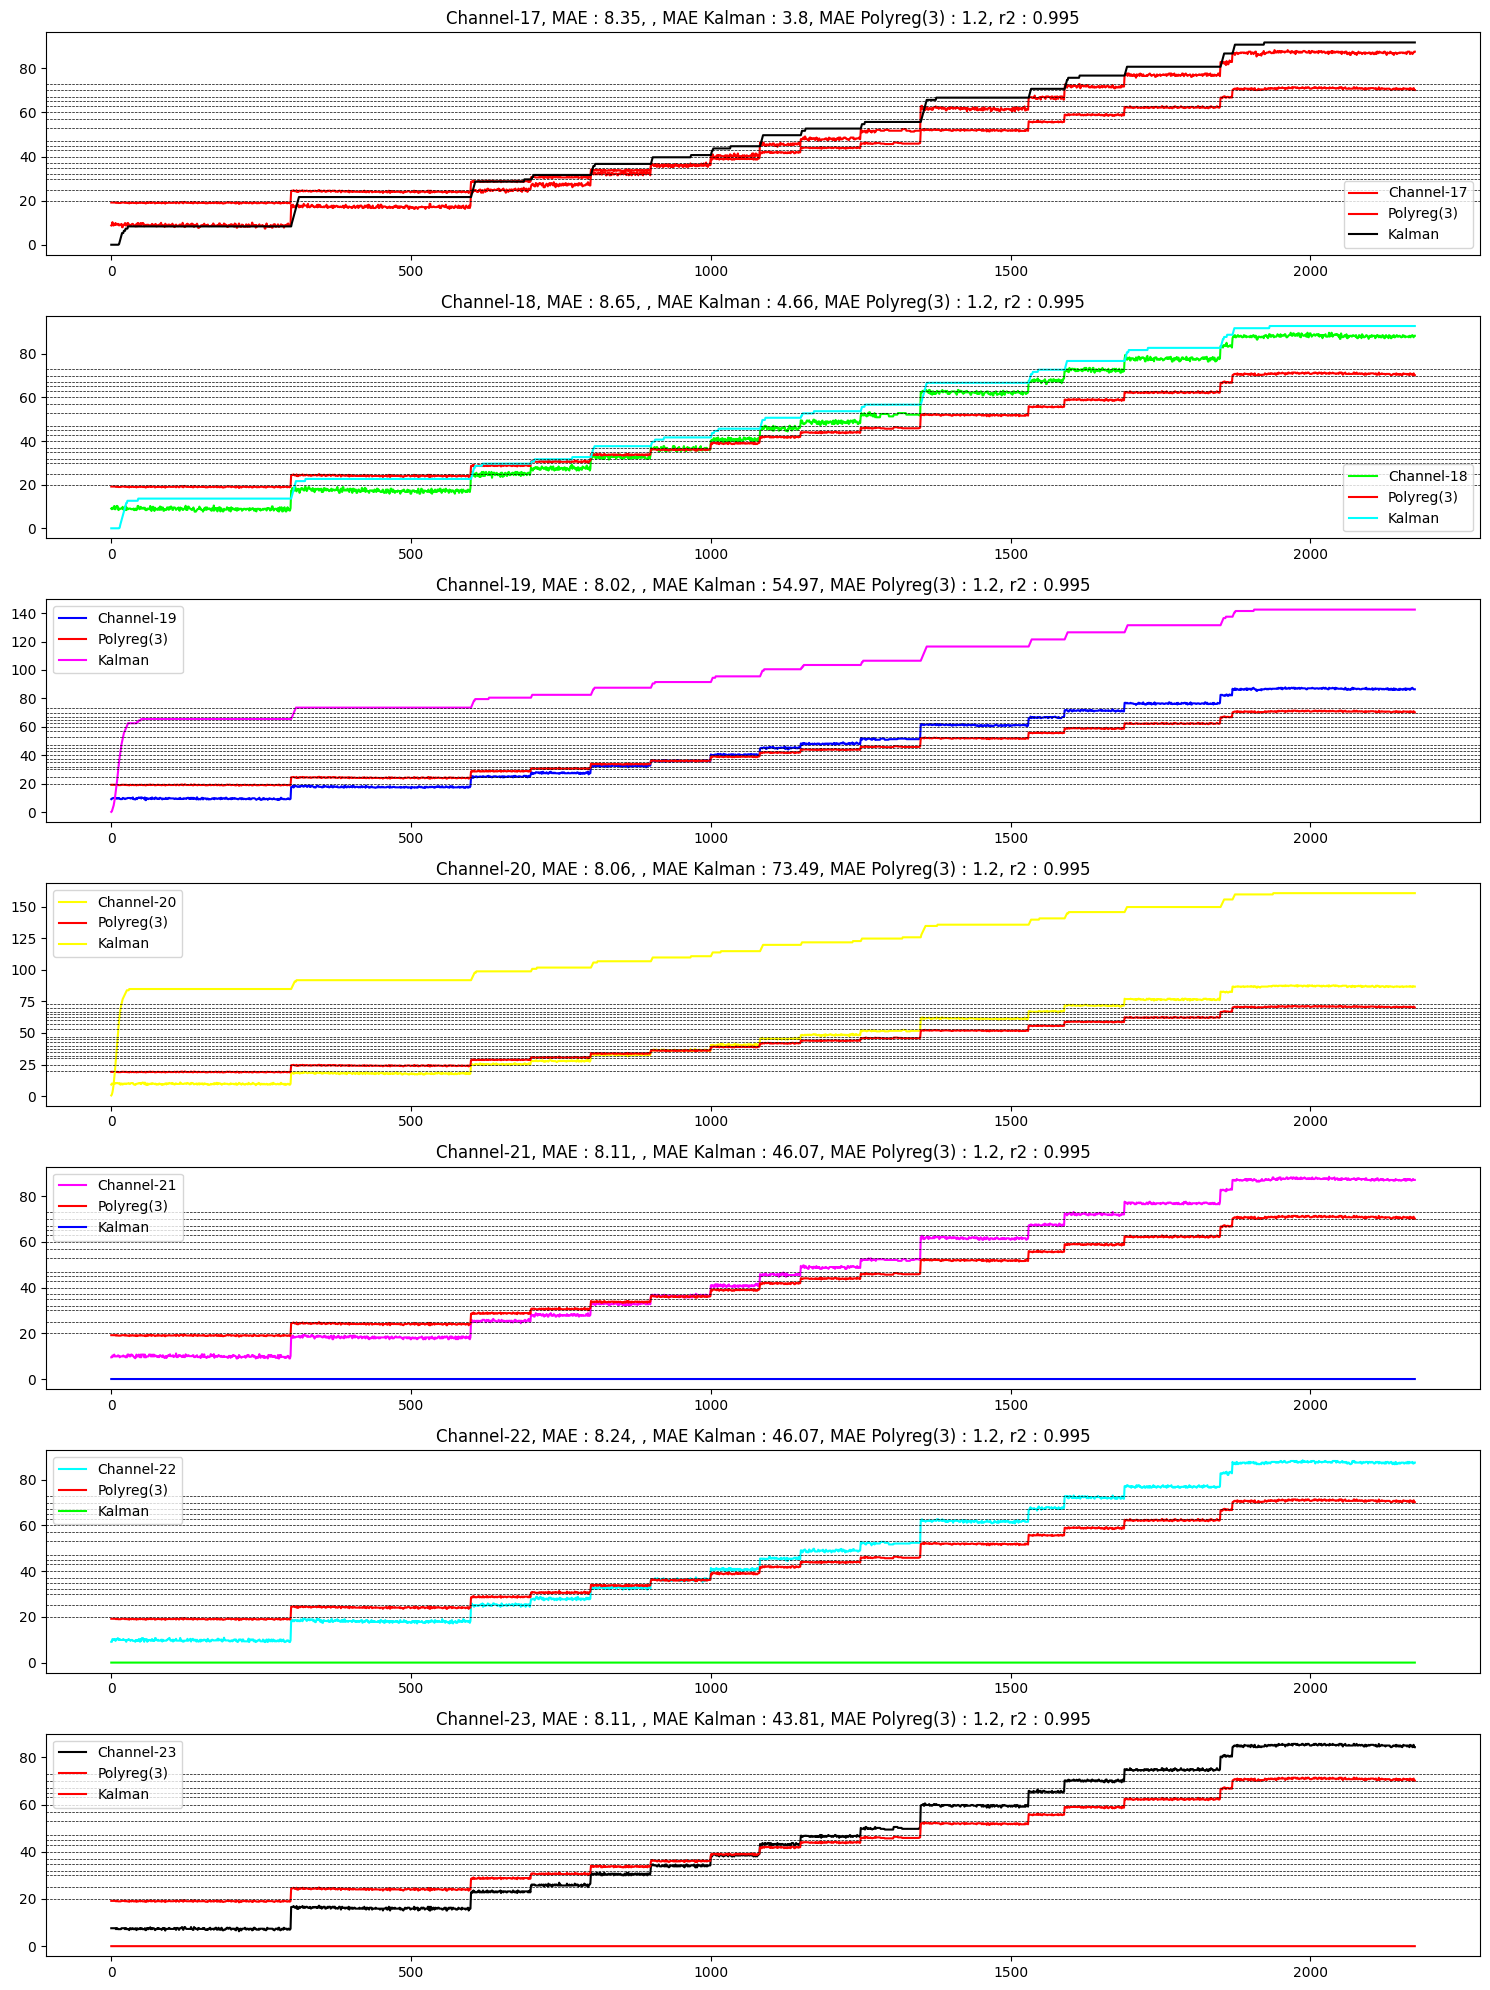

In [88]:
fig, ax = plt.subplots(7,1,figsize=(15,20))
for i, pin in enumerate(PIN_NAME):
    ax[i].plot(df.index, df[pin], label=f"{pin}", color=colors[i])
    ax[i].plot(df.index, f, label=f"Polyreg(3)", color='r')
    ax[i].plot(df.index, np.squeeze(calculate_kalman(df[pin].to_list(), u, std_acc)), label=f"Kalman", color=colors[6-i])
    ax[i].set_title(f"{pin}, MAE : {round(mae((df.SETPOINT), df[pin]), 2)}, , MAE Kalman : {round(mae(np.squeeze(calculate_kalman(df[pin].to_list(), u, std_acc)), df[pin]), 2)}, MAE Polyreg(3) : {round(mae(df.SETPOINT, f), 2)}, r2 : {round(r2_score(df.SETPOINT, f), 3)}")
    ax[i].legend()

    for j in df["SETPOINT"].unique():
        ax[i].axhline(j, 0, len(df.index), linestyle="--", linewidth=0.5, color='k')
plt.tight_layout()
plt.show()
